# Image segmentation
ต่างกับ Object detection คือมีความละเอียดมากกว่าเพราะสามารถบอกว่าวัตถุนั้นคืออะไร ในระดับ Pixel ซึ่งจะระบายสีตามแต่ละ object ไม่ได้เป็นการตีกรอบเหมือน Object detection
เช่น Model SAM, SlimSAM (ใช้บนอุปกรณ์ที่ทรัพยากรจำกัดได้)

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from transformers import pipeline

In [2]:
model = 'Zigeng/SlimSAM-uniform-77'
seg_pipe = pipeline('mask-generation', model=model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [3]:
!wget https://media.wired.com/photos/593256b42a990b06268a9e21/master/pass/traffic-jam-getty.jpg -O cars.jpg

--2025-10-06 14:27:26--  https://media.wired.com/photos/593256b42a990b06268a9e21/master/pass/traffic-jam-getty.jpg
Resolving media.wired.com (media.wired.com)... 3.163.158.79, 3.163.158.128, 3.163.158.104, ...
Connecting to media.wired.com (media.wired.com)|3.163.158.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194495 (190K) [image/jpeg]
Saving to: ‘cars.jpg’

cars.jpg            100%[===================>] 189.94K  --.-KB/s    in 0.02s   

2025-10-06 14:27:26 (8.71 MB/s) - ‘cars.jpg’ saved [194495/194495]



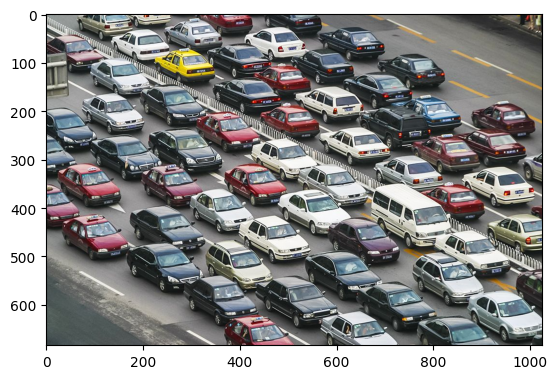

In [4]:
image = Image.open('cars.jpg')
plt.imshow(image)
plt.show()

In [5]:
result = seg_pipe(image)
result

{'masks': [array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False]]),
  array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, 

In [6]:
result.keys()

dict_keys(['masks', 'scores'])

In [7]:
len(result['masks'])

214

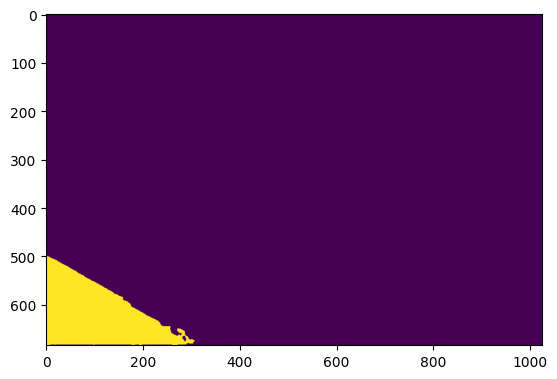

In [8]:
plt.imshow(result['masks'][0])
plt.show()
# การใช้งานจริงการใช้แค่ 1 masks อาจะไม่เพียงพอ อาจะต้องใข้ masks อื่นๆ ไป overrate เพิ่ม
# หรือวางทับบนภาพ original

In [51]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
  if random_color:
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    # ต่อ array ของ random color กับ ค่า โปร่งใส
  else:
    color = np.array([30/255, 144/255, 255/255, 0.6])
  h,w = mask.shape[-2:]
  mask_image = mask.reshape(h,w,1) * color.reshape(1,1,-1)
  ax.imshow(mask_image)


In [14]:
def show_pipe_masks_on_image(raw_image, outputs):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  for mask in outputs['masks']:
    show_mask(mask, ax=ax, random_color=True)
  # plt.axis('off')
  plt.show()

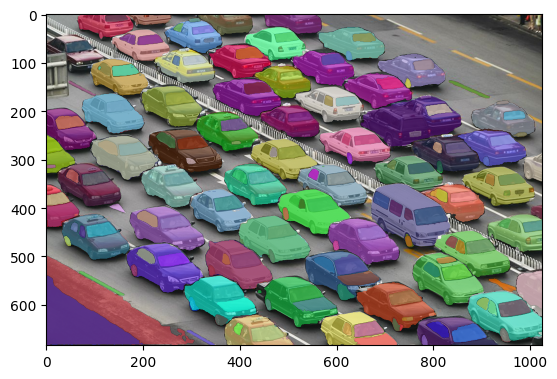

In [15]:
show_pipe_masks_on_image(image, result)

In [12]:
# normally จะนำผลลัพธ์จาก mask generatation ไปเข้า classification ต่อเพื่อตีความหมาย

**ทำ Segmentation แบบกำหนดจุด**  
จะต้องทำผ่านการโหลดmodel โตยตรงแต่ไม่สามารถใช้ pipeline ได้

In [16]:
from transformers import SamModel, SamProcessor

model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-77").to("cuda")
processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-77")

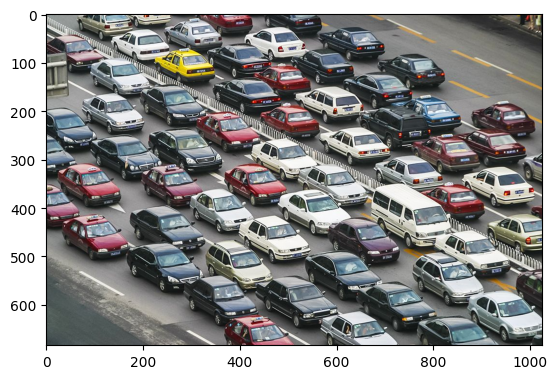

In [17]:
plt.imshow(image)
plt.show()

In [32]:
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# recheck alread cuda work

True


In [33]:
input_points = [[[250, 450]]] # format be list of list of list
inputs = processor(image,input_points=input_points, return_tensors="pt").to(device)
# change inputs from cpu to gpu before processing
# return type be pytorch sensors

In [30]:
import torch
# torch no grad ใช้บอกเพื่อจะใข้งาน model โดยไม่มีการ update model ในช่วงการใช้งาน
with torch.no_grad():
  output = model(**inputs) # format be two *
predicted_masks = processor.image_processor.post_process_masks(
    output.pred_masks,
    inputs['original_sizes'],
    inputs['reshaped_input_sizes']
)

In [35]:
predicted_masks[0].shape
# 3 สื่อถึงมี 3 candidate masks, 2 ตัวหลังคือ high width

torch.Size([1, 3, 684, 1025])

In [38]:
output.iou_scores
# สื่อถึงความมันใจของแต่ละ mask มีค่าเท่าไหร

tensor([[[0.9053, 0.8302, 0.8795]]], device='cuda:0')

In [60]:
def show_mask_on_image(raw_image, mask):
  if not isinstance(mask, torch.Tensor):
    masks = torch.Tensor(mask)
  if len(mask.shape) == 4:
    mask = mask.squeeze()
    # บาง model จะมี shape เป็นสีตัวก็ใช้ squeeze เพื่อลด มิติให้เหลือสามมิติโดยการลบตัวแรกออกไป
  print(mask.shape)
  fig, axes = plt.subplots(1,1, figsize=(15,15))
  mask = mask.cpu().detach()
  # ย้าย mask จาก tensor มาที่ cpu แล้วแยก tensor จากการคำนวณออกมา
  axes.imshow(np.array(raw_image))
  show_mask(mask,axes)
  plt.show()

/tmp/ipython-input-1982182358.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mask_image = mask.reshape(h,w,1) * color.reshape(1,1,-1)


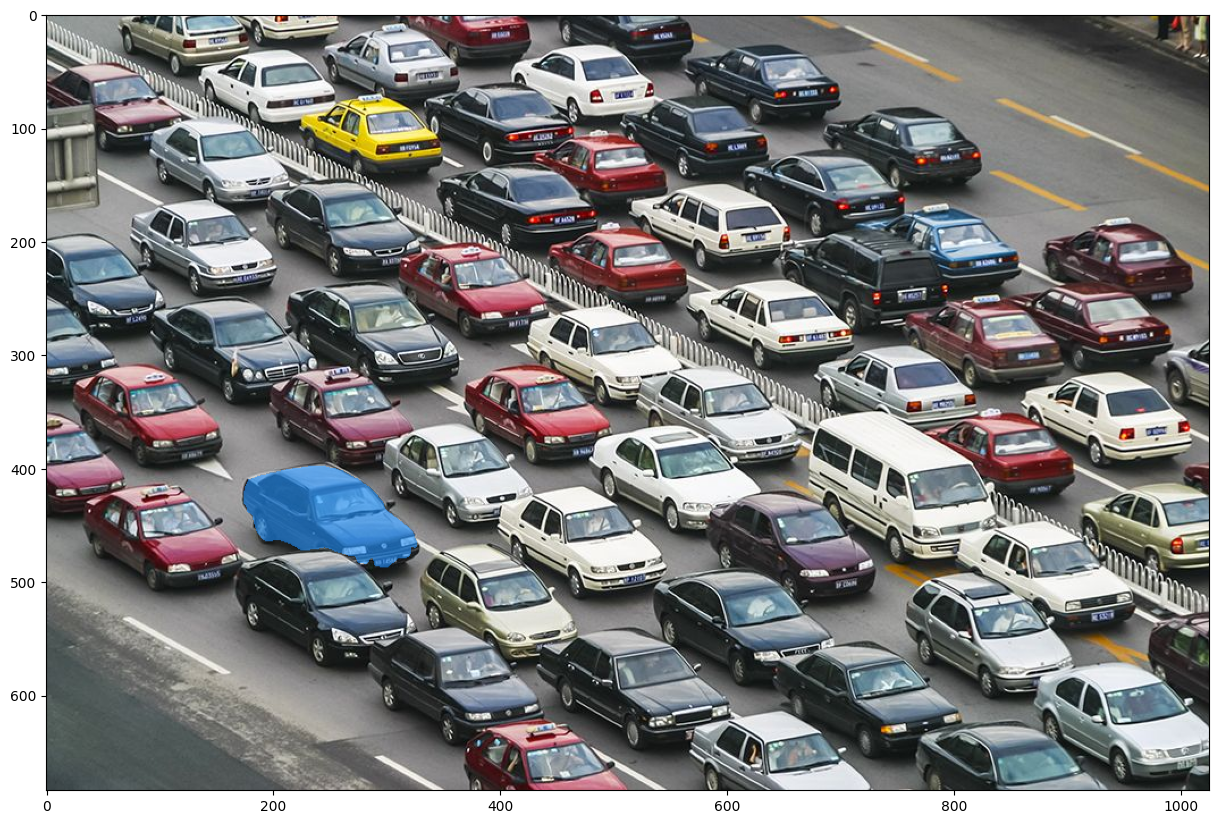

In [58]:
for i in range(len(predicted_masks[0][:])):
  show_mask_on_image(image, predicted_masks[0][:,i])

**Depth Estimation**  
คือการประมาณความลึกจากภาพ เช่น Model DPT-Hybrid

In [61]:
from transformers import pipeline

In [62]:
model = 'Intel/dpt-hybrid-midas'
depth_estimator = pipeline('depth-estimation', model=model)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/490M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/490M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

Device set to use cuda:0


In [63]:
result_depth = depth_estimator(image)

In [66]:
result_depth

{'predicted_depth': tensor([[   2.6012,    2.6611,    2.8571,  ...,   29.2189,   29.3366,
            29.4662],
         [   2.8638,    3.0144,    3.4147,  ...,   30.9180,   31.9858,
            32.5134],
         [   3.4595,    3.7268,    4.3867,  ...,   33.0341,   35.3576,
            36.4099],
         ...,
         [1593.8741, 1593.7523, 1593.3381,  ..., 1817.5129, 1812.9893,
          1811.1577],
         [1587.9856, 1588.9158, 1591.1482,  ..., 1814.4332, 1810.2861,
          1808.4528],
         [1583.2947, 1584.9977, 1589.1793,  ..., 1812.3832, 1808.7146,
          1806.9542]]),
 'depth': <PIL.Image.Image image mode=L size=1025x684>}

In [67]:
result_depth.keys()

dict_keys(['predicted_depth', 'depth'])

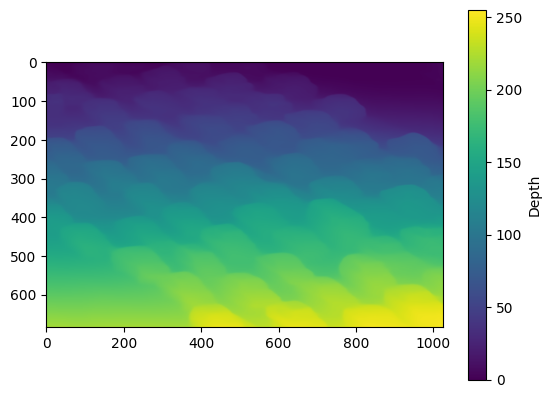

In [70]:
plt.imshow(result_depth['depth'])
plt.colorbar(label='Depth')
plt.show()
# ยิ่งใกล้จะมีค่ามาก ยิ่งไกลจะน้อย